Hamilton,W.L. *Graph Representation Learning*. 2020

# 그래프 통계량과 커널 방법

**Graph Statistics and Kernel Methods**

딥러닝과 관련된 그래프(GNN 등)를 알아보기 전에 전통적인 방식의 그래프 통계량을 알아보자.

그래프 데이터를 사용하는 전통적인 분류는 딥러닝 등장 이전의 머신러닝 패러다임을 따른다. 몇 가지 통계량 또는 특징을 추출한 다음, 머신러닝 분류기(예: 로지스틱 회귀)의 입력으로 사용한다. 

이 섹션에서는 먼저 중요한 **노드 레벨의 피쳐와 통계량**을 소개한 다음, 이러한 노드 수준 통계량이 **그래프 레벨 통계량으로 일반화**되고 그래프 상에서의 **커널 방법**을 설계하는 방법에 대해 논의한다.

*그래프 커널(Graph Kernel)은 두 개의 그래프 간의 유사성을 계산하기 위한 도구*

## Node-level 통계량과 피쳐(features)

In [43]:
import networkx as nx
import matplotlib.pyplot as plt

# Barabási-Albert 그래프 생성
n = 8  # 노드 개수
m = 2    # 새로운 노드에 연결되는 엣지 수
G = nx.barabasi_albert_graph(n, m)

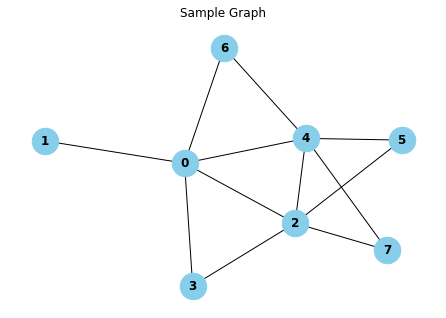

In [44]:
# 시각화
pos = nx.spring_layout(G)  # 그래프 레이아웃 정의

# 노드 및 엣지 그리기
nx.draw(G, pos, with_labels=True, node_size=700, node_color="skyblue", font_size=12, font_weight="bold")
plt.title("Sample Graph")
plt.show()

### Node degree

한 노드에 연결된 엣지 수

$$d_u = \sum_{v \in V}A[u,v] \quad \text{for } u \in \mathcal{V}$$

- node degree는 전통적 기계학습 모델에서 가장 유익한 정보 중 하나이다. 
- 하지만, 한 노드와 연결된 다른 노드들의 중요성은 노드의 degree에 반영되지 않는다. 즉, 두 노드가 같은 degree를 갖더라도 이웃의 중요도에 따라 중요도가 다를 수 있다.

In [45]:
# Node degree 구하기
degree = dict(G.degree())
print("Node degree:")
print(degree)

Node degree:
{0: 5, 1: 1, 2: 5, 3: 2, 4: 5, 5: 2, 6: 2, 7: 2}


### Node centrality

위세 중심성 (eigenvector centrality)

- node degree와 달리, **노드의 이웃들의 중요도**까지 고려하는 방법이다.

$$e_u = \frac{1}{\lambda}\sum_{v \in V}A[u,v] e_v, \quad \forall u \in \mathcal{V}$$

- 식처럼 recursive한 성질을 가진다. 
- 단, 위의 식을 다시 쓰면 벡터 $\mathbf{e}$에 대해 $\lambda \mathbf{e} = A \mathbf{e}$와 같다. 즉, centrality는 인접행렬의 eigenvector이다. 양의 centrality 값을 가정하면, Perron-Frobenius Theorem을 적용하여 $\mathbf{e}$를 구할 수 있다.

- 또한, eigenvector centrality느 그래프에서 무한 랜덤워킹할 때 해당 노드에 도착할 확률이라고도 볼 수 있다.
    - $\mathbf{e}^{(t+1)} = A \mathbf{e}^{(t)}$ : power iteration

매개 중심성 (betweenness centrality): 한 노드가 다른 두 노드 사이의 최단 경로에 있을 빈도

근접 중심성 (closeness centrality): 한 노드와 다른 모든 노드 사이 최단거리들의 평균

차수 중심성(degree centrality): 해당 노드의 직접적인 연결 수를 기준으로 측정

In [46]:
# Degree centrality 구하기
degree_centrality = nx.degree_centrality(G)
print("Degree centrality:")
print(degree_centrality)

# Betweenness centrality 구하기
betweenness_centrality = nx.betweenness_centrality(G)
print("\nBetweenness centrality:")
print(betweenness_centrality)

# Closeness centrality 구하기
closeness_centrality = nx.closeness_centrality(G)
print("\nCloseness centrality:")
print(closeness_centrality)

# Eigenvector centrality 구하기
eigenvector_centrality = nx.eigenvector_centrality(G)
print("\nEigenvector centrality:")
print(eigenvector_centrality)

Degree centrality:
{0: 0.7142857142857142, 1: 0.14285714285714285, 2: 0.7142857142857142, 3: 0.2857142857142857, 4: 0.7142857142857142, 5: 0.2857142857142857, 6: 0.2857142857142857, 7: 0.2857142857142857}

Betweenness centrality:
{0: 0.38095238095238093, 1: 0.0, 2: 0.23809523809523808, 3: 0.0, 4: 0.23809523809523808, 5: 0.0, 6: 0.0, 7: 0.0}

Closeness centrality:
{0: 0.7777777777777778, 1: 0.4666666666666667, 2: 0.7777777777777778, 3: 0.5833333333333334, 4: 0.7777777777777778, 5: 0.5384615384615384, 6: 0.5833333333333334, 7: 0.5384615384615384}

Eigenvector centrality:
{0: 0.45764291396672224, 1: 0.12765413188341646, 2: 0.4916986269732836, 3: 0.2648068579411542, 4: 0.4916986269732836, 5: 0.27430545232366466, 6: 0.2648068579411542, 7: 0.27430545232366466}


### Clustering Coefficient

한 노드의 로컬(local) 이웃에서의 closed triangle의 비율

- clustering coefficient의 변형 중 'local' variant를 보자.
$$c_u = \frac{|(v_1,v_2) \in \mathcal{E}: v_1, v_2 \in \mathcal{N}(u)|}{\binom{d_u}{2}}$$
    - 분자는 노드 $u$의 이웃 간 엣지 수이고, 분모는 $u$의 이웃에 있는 노드 쌍의 수이다.

- 노드의 이웃이 얼마나 tight하게 클러스터되어 있는지를 측정한다.
- clustering coefficient가 1이면, $u$의 모든 이웃은 서로의 이웃이기도 하게 된다.

In [47]:
# Clustering coefficient 구하기
clustering_coefficient = nx.clustering(G)
print("\nClustering coefficient:")
print(clustering_coefficient)


Clustering coefficient:
{0: 0.3, 1: 0, 2: 0.4, 3: 1.0, 4: 0.4, 5: 1.0, 6: 1.0, 7: 1.0}


### Closed Triangles, Ego Graphs, and Motif

- clustering coefficient는 노드의 로컬 이웃 사이에 있는 **closed triangle**의 수라고 볼 수도 있다.

- clustering coefficient는 실제 triangle의 수와 노드의 '**ego graph**'의 총 가능 triangle 수의 비이기도 하다. 
     - ego graph: 노드, 이웃, 이웃 간 모든 엣지를 포함하는 subgraph

- 노드의 ego graph 내 임의의 motif나 graphlet을 세는 개념으로 일반화될 수 있다. 즉, 단순히 triangle을 세는 것보다는 특정 길이의 순환과 같은 복잡한 구조를 고려할 수 있고, 이러한 서로 다른 motif가 ego graph에서 얼마나 자주 발생하는지 세는 것으로 노드를 특성화할 수 있다. 

- motif: 네트워크에서 특정한 패턴을 가진 서브그래프를 찾아내는 것
  
- 이러한 방식으로 노드의 ego graph를 조사하여 노드 레벨의 통계량을 계산하는 작업을 그래프 레벨로 근본적으로 변환할 수 있다.

In [54]:
closed_triangles = nx.triangles(G).values()
print("Closed Triangles:", closed_triangles)

Closed Triangles: dict_values([3, 0, 4, 1, 4, 1, 1, 1])


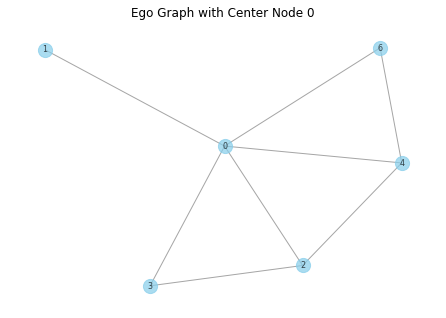

In [55]:
node=0
ego_graph = nx.ego_graph(G, n=node, radius=1)
pos = nx.spring_layout(ego_graph)  # 그래프 레이아웃 정의
nx.draw(ego_graph, pos, with_labels=True, node_size=200, node_color="skyblue", edge_color="gray", alpha=0.7, font_size=8)
plt.title("Ego Graph with Center Node " + str(node))
plt.show()

## Graph-level 피쳐와 그래프 커널

### Bag of Nodes
- 단순히 **node-level의 통계량을 집계**하여 graph-level 피쳐로 만든다. 
- 하지만, 로컬(local) node-level의 정보만에 기반하기 때문에 글로벌(global)한 속성을 놓칠 수 있다.

### The Weisfieler-Lehman Kernel

- node-level 피처를 더 풍성하게 만들고나서 집계하는 방법 중 하나이다.

- WL 알고리즘은 다음과 같다.
    - 1. 각 노드에 초기 레이블 값을 준다. 보통 degree로 한다.: $l^{(0)}(v) = d_v$
    - 2. 노드의 이웃에서 현재 레이블의 multi-set을 hashing하여 새로운 레이블을 할당하며, 이를 반복(iteration)한다.: $$l^{(i)}(v) = \text{HASH}(\{ \{ l^{(i-1)}(v) \quad \forall u \in \mathcal{N}(v) \} \} )$$
        - {{ }}는 mult-set을 뜻한다. multi-set은 원소의 중복을 허용
        - HASH  함수는 multi-set으로 표현될 뻔한 레이블에 겹치지 않는 인덱스 (숫자)를 부여해주는 역할
     - 3. 이를 $K$번 반복하면 각 노드마다 $l^{(K)}(v)$가 생기며, 이는 $K$-hop 이웃의 구조를 요약한다고 볼 수 있다. 다시 말해, WL kernel은 두 그래프의 결과 레이블 집합 간의 차이를 측정하는 것이다.
    
- 이러한 WL kernel은 그래프 동형(isomorphism)을 확인하는 데 쓰인다: 두 그래프가 $K$번 WL알고리즘 반복 뒤 생기는 레이블 집합이 같은지를 확인한다.

### Graphlets, Path-Based Methods

**graphlets**

<img src="img/fig2_2.png" width='500'>

> Figure 2.2 in Hamilton,*Graph Representation Learning*. 2020: 크기가 3인 graphlet들

- graphlets: 서로 다른 작은 subgraph 구조
- graphlet kernel은 전체 그래프에서 특정한 크기의 graphlets가 얼마나 나타나는지 세는 방식이다. 하지만 모든 graphlet을 세는 것은 번거로운 일이다.

**path-based 방법**

- graphlet을 세는 방법 대신 그래프에서 서로 다른 경로(path)의 종류가 얼마나 있는지를 본다.
- 예를 들어 그래프에서 랜덤워크를 가정할때 발생하는 서로 다른 degree 시퀀스를 카운팅하는 random walk kernel(Kashima et al.(2003)), 또는 가장 짧은 경로만을 카운팅하는 shortest-path kernel(Borgwardt and Kriegel (2005)) 등이 있다.

# 참고자료

- Hamilton, W. L. (2020). *Graph Representation Learning.* Morgan & Claypool Publishers.

- NetworkX
- ChatGPT
